# Toxicity Detection in Memes 

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/toxicity-classification/blob/main/README.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/toxicity-classification/blob/main/README.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="
    https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/README.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>
<br>
<br>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [1]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File '00-start-eva-server.ipynb' already there; not retrieving.


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
nohup eva_server > eva.log 2>&1 &

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Load the Memes for analysis

In [2]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/meme1.jpg"
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/meme2.jpg"
cursor.execute('DROP TABLE IF EXISTS MemeImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "meme1.jpg" INTO MemeImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "meme2.jpg" INTO MemeImages;')
response = cursor.fetch_all()
print(response)

--2023-05-07 22:29:43--  https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/meme1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56209 (55K) [image/jpeg]
Saving to: 'meme1.jpg'

meme1.jpg           100%[===================>]  54.89K  --.-KB/s    in 0.02s   

2023-05-07 22:29:43 (3.49 MB/s) - 'meme1.jpg' saved [56209/56209]

--2023-05-07 22:29:44--  https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/meme2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36192 (35K) [im

### Create OCR Extractor UDF

In [3]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/ocr_extractor.py"
cursor.execute("DROP UDF OCRExtractor;")
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF IF NOT EXISTS OCRExtractor
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
              scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'ocr_extractor.py';
      """)
response = cursor.fetch_all()
print(response)

File 'ocr_extractor.py' already there; not retrieving.

@status: ResponseStatus.SUCCESS
@batch: 
                                        0
0  UDF OCRExtractor successfully dropped
@query_time: 0.03767251595854759
@status: ResponseStatus.SUCCESS
@batch: 
                                                       0
0  UDF OCRExtractor successfully added to the database.
@query_time: 5.711085919290781


### Create Custom UDF for Toxicity Classification

In [17]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/toxicity_classifier.py"
cursor.execute("DROP UDF IF EXISTS ToxicityClassifier;")
response = cursor.fetch_all()
print(response)
cursor.execute("""
            CREATE UDF ToxicityClassifier
            TYPE HuggingFace
            'task' 'text-classification'
            'model' 'EIStakovskii/xlm_roberta_base_multilingual_toxicity_classifier_plus';
      """) 
response = cursor.fetch_all()
print(response)

File 'toxicity_classifier.py' already there; not retrieving.

@status: ResponseStatus.SUCCESS
@batch: 
 Empty DataFrame
Columns: []
Index: []
@query_time: 0.015794897451996803
@status: ResponseStatus.SUCCESS
@batch: 
                                                             0
0  UDF ToxicityClassifier successfully added to the database.
@query_time: 3.7653132677078247


### Run Toxicity Classifier on OCR Extracted from Images

In [19]:
cursor.execute("""SELECT T.label, ToxicityClassifier(T.label)
                  FROM MemeImages JOIN LATERAL
                  UNNEST(OCRExtractor(data)) AS T(label, bbox, score)
                  ;""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                T.label toxicityclassifier.label  toxicityclassifier.score
0      CAN'T FucK WITH                  LABEL_0                  0.932346
1          MEIN SWAG E                  LABEL_1                  0.999521
2       YOU CANT SPELL                  LABEL_0                  0.994370
3  CLINTON WITHOUT CNN                  LABEL_0                  0.999781
4           Imgmup-coM                  LABEL_0                  0.996063
@query_time: 12.812345305457711


### Visualize Model Output on Images

In [25]:
from pprint import pprint
from matplotlib import pyplot as plt
import cv2
import numpy as np

def annotate_image(detections, input_image_path, image_id):

    print(detections)

    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    df = detections
    df = df[df.index == image_id]

    image = cv2.imread(input_image_path)

    if df.size:
        df_value_list = df.values
        ocr = ' '.join(df_value_list[0][0])
        label = df_value_list[0][1]
        print(label)

        if label == "LABEL_0":
            actual_label = "NOT TOXIC"
        else:
            actual_label = "TOXIC"

        plt.imshow(image)
        plt.show()

        cv2.putText(image, actual_label, (25, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, color2, thickness, cv2.LINE_AA) 

        cv2.putText(image, ocr, (25, 250), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color1, thickness, cv2.LINE_AA) 

        plt.imshow(image)
        plt.show()        

               T.label toxicityclassifier.label  toxicityclassifier.score
0      CAN'T FucK WITH                  LABEL_0                  0.932346
1          MEIN SWAG E                  LABEL_1                  0.999521
2       YOU CANT SPELL                  LABEL_0                  0.994370
3  CLINTON WITHOUT CNN                  LABEL_0                  0.999781
4           Imgmup-coM                  LABEL_0                  0.996063
LABEL_0


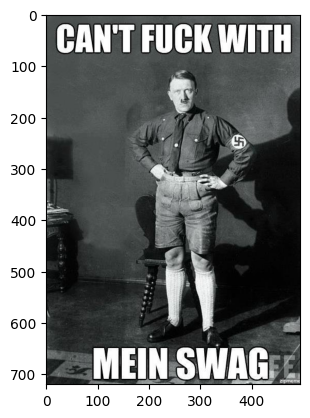

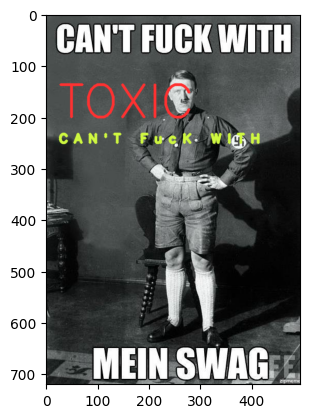

               T.label toxicityclassifier.label  toxicityclassifier.score
0      CAN'T FucK WITH                  LABEL_0                  0.932346
1          MEIN SWAG E                  LABEL_1                  0.999521
2       YOU CANT SPELL                  LABEL_0                  0.994370
3  CLINTON WITHOUT CNN                  LABEL_0                  0.999781
4           Imgmup-coM                  LABEL_0                  0.996063
LABEL_1


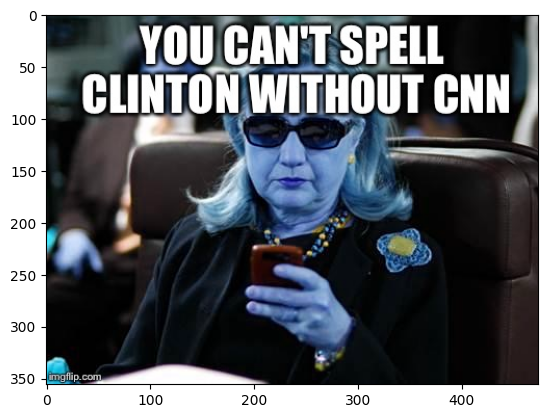

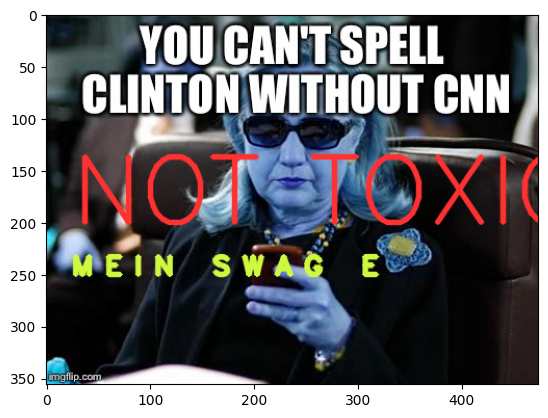

In [24]:
from ipywidgets import Image
dataframe = response.batch.frames
annotate_image(dataframe, 'meme1.jpg', image_id=0)
annotate_image(dataframe, 'meme2.jpg', image_id=1)